# Analysis Assignment 1.2.2
## Estimating trip generation

This is an example you can follow to complete Assignment 1.2.2 

In the example below, I estimate zone-level trip generation for the Buffalo-Cheektowaga-Niagra Falls Metropolitan Statistical Area in 4 steps (or 10 steps, depending on how you want to count):
0. Load required libraries
1. Estimate trip productions    
   1.1 Load zonal household data  
   1.2 Visualize zonal household data     
   1.3 Load coefficient estimates from assignment 1.2.1    
   1.4 Estimate zonal productions
2. Estimate trip attractions  
   3.1 Load zonal employment data  
   3.2 Visualize zonal employment data  
   3.3 Estimate zonal attractions
3. Balance productions and attractions
4. Visualize final result

### Step 0: Load required libraries
You'll need these seven libraries to run this script.

In [1]:
library(geojsonio)
library(ggthemes)
library(lehdr)
library(sf)
library(stats)
library(tidycensus)
library(tidyverse)


Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty


Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



### Step 1: Estimate trip productions
We'll use the model we developed in the previous assignment (Assignment 1.2.1)

We can apply that model to estimate the number of daily trips produced by each zone. We'll do this in 4 steps:
1. Load zonal household data
2. Visualize zonal household data
3. Load coefficient estimates from Assignment 1.2.1
4. Estimate zonal productions

#### Step 1.1 Load zonal household data
In assignment 1.2.1, we estimated a model that predicts the number of daily trips per household based on household size, number of vehicles per household, income, race/ethnicity, and residential density.

To use that model to predict trip productions for each zone, we need to get average zonal values for each of those variables. We'll use census tracts for our zones, so we can use census data for our analysis.

We can get the data we need from the Census API using the tidycensus package. 

Before you use tidycensus the first time, you'll need to get an API key from http://api.census.gov/data/key_signup.html. Once you have a key, paste it into a text editor and save the file containing your API key in your working directory (your repo) as "census_key.txt" I've already added this file name to the repo .gitignore file, so the file won't get copied to github when you submit your pull request.

The Buffalo MSA comprises two counties: Erie and Niagara.

In [2]:
key <- read_file("census_key.txt")
census_api_key(key)

To install your API key for use in future sessions, run this function with `install = TRUE`.



Next, you'll need to make a list of all the variables you want to grab. The hardest part of this is figuring out the names of the census variables. Kyle Walker (author of the tidycensus package) has a recommendation for how to search for variables if you're working in RStudio. See https://walker-data.com/tidycensus/articles/basic-usage.html. I've also compiled a list of useful, relevant variables [here](https://github.com/GSD-SES-5394/assignment-1-2-2/blob/master/census-variables.md).

You'll need to get variables corresponding to all of the predictors in the model you estimatated in Assignment 1.2.1 (or you'll need whatever variables you need to calculate those predictors), and you'll also need the total number of households.

In [3]:

vars = c(num_HH = "B08201_001",
        HHSIZ = "B25010_001", # not a typo; the E gets added later.
        HH_1VEH = "B08201_003",
        HH_2VEH = "B08201_004",
        HH_3VEH = "B08201_005",
        HH_4VEH = "B08201_006",
        HHFAMINC = "B06011_001",
        num_HUs = "B25001_001",
        tot_pop = "B01003_001",
        white_pop = "B03002_003",
        black_pop = "B03002_004",
        hisp_pop = "B03002_012",
        asian_pop = "B03002_006")

Now you'll use the `get_acs()` function from tidycensus get the values of those variables for each tract in your study area. The Buffalo MSA includes two counties: Erie and Niagara.

In [4]:
tracts <- get_acs(geography = "tract", variables = vars, 
                  state = "NY", county = c("Erie", "Niagara"), 
                  geometry = TRUE, output = "wide") %>%
  mutate(HHVEHCNT = 
         (HH_1VEHE + 2*HH_2VEHE + 3*HH_3VEHE + 4*HH_4VEHE)/num_HHE) %>%
  mutate(income_k = HHFAMINCE/1000) %>%
  mutate(pct_white = white_popE / tot_popE) %>%
  mutate(pct_black = black_popE / tot_popE) %>%
  mutate(pct_hisp = hisp_popE / tot_popE) %>%
  mutate(pct_asian = asian_popE / tot_popE) %>%
  mutate(pct_other = 1 - pct_white - pct_black - pct_hisp - pct_asian) %>%
  st_transform(2828)  %>% # makes it so you can calculate the tract area
  mutate(sq_mi = as.numeric(st_area(.))/(5280^2)) %>% #5280 feet per mile
  mutate(HBRESDN = num_HUsE / sq_mi) %>%
  rename(num_HH = num_HHE) %>%
  filter(tot_popE > 0) %>%
  select(GEOID, HHSIZE, HHVEHCNT, income_k, pct_white, pct_black, pct_hisp, pct_asian,
         pct_other, HBRESDN, num_HH)

head(tracts)

Getting data from the 2014-2018 5-year ACS




  |======================================================================| 100%


,GEOID,HHSIZE,HHVEHCNT,income_k,pct_white,pct_black,pct_hisp,pct_asian,pct_other,HBRESDN,num_HH,geometry
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
1,36029017300,2.37,1.7742156,42.048,0.9828964,0.003364643,0.005888126,0.00364503,0.004205804,8638.4119,2932,MULTIPOLYGON (((-197779.6 4...
2,36029017400,3.13,1.1489971,19.423,0.4717327,0.257267109,0.136873426,0.01808194,0.116044862,5408.0001,1396,MULTIPOLYGON (((-207485.7 4...
3,36029017501,2.09,1.3121212,28.829,0.8766737,0.003523608,0.021141649,0.01973221,0.078928823,3441.7670,660,MULTIPOLYGON (((-215285.5 4...
4,36029017502,2.43,1.9789474,28.630,0.9750859,0.003865979,0.010309278,0.00000000,0.010738832,256.5629,950,MULTIPOLYGON (((-215157.7 4...
5,36029000110,2.73,1.2553191,20.791,0.7019095,0.018741160,0.262376238,0.00000000,0.016973126,3770.6634,1034,MULTIPOLYGON (((-207344.1 4...
6,36029005801,2.58,0.9292717,17.535,0.5062534,0.110386079,0.249320283,0.04323002,0.090810223,61713.5164,1428,MULTIPOLYGON (((-209712.6 4...


#### Step 1.2 Visualize zonal household data
We'll start with average household size.

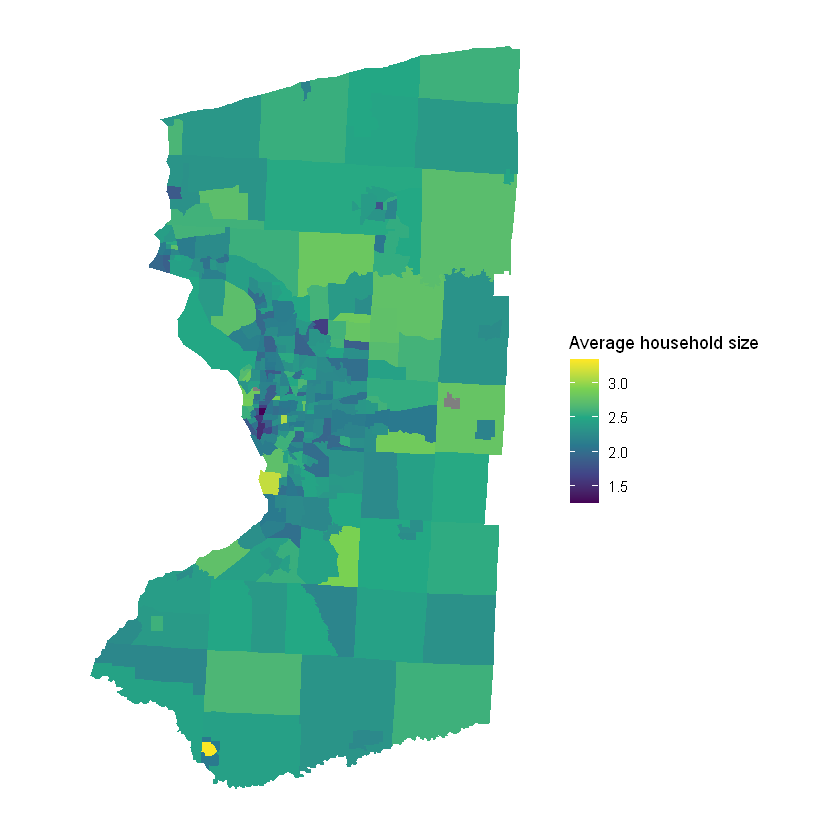

In [5]:
ggplot(tracts, aes(fill = HHSIZE)) + 
  geom_sf(color = NA) + 
  scale_fill_viridis_c("Average household size") + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank()) 

Next, we'll do vehicle ownership:

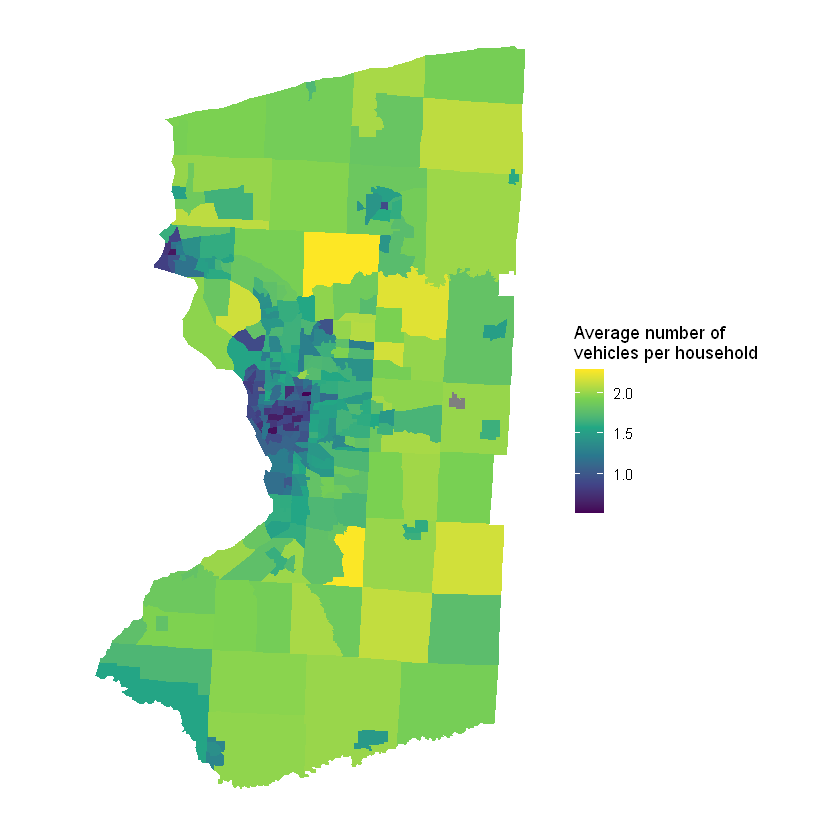

In [6]:
ggplot(tracts, aes(fill = HHVEHCNT)) + 
  geom_sf(color = NA) + 
  scale_fill_viridis_c("Average number of\nvehicles per household") + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank()) 

Then median income:

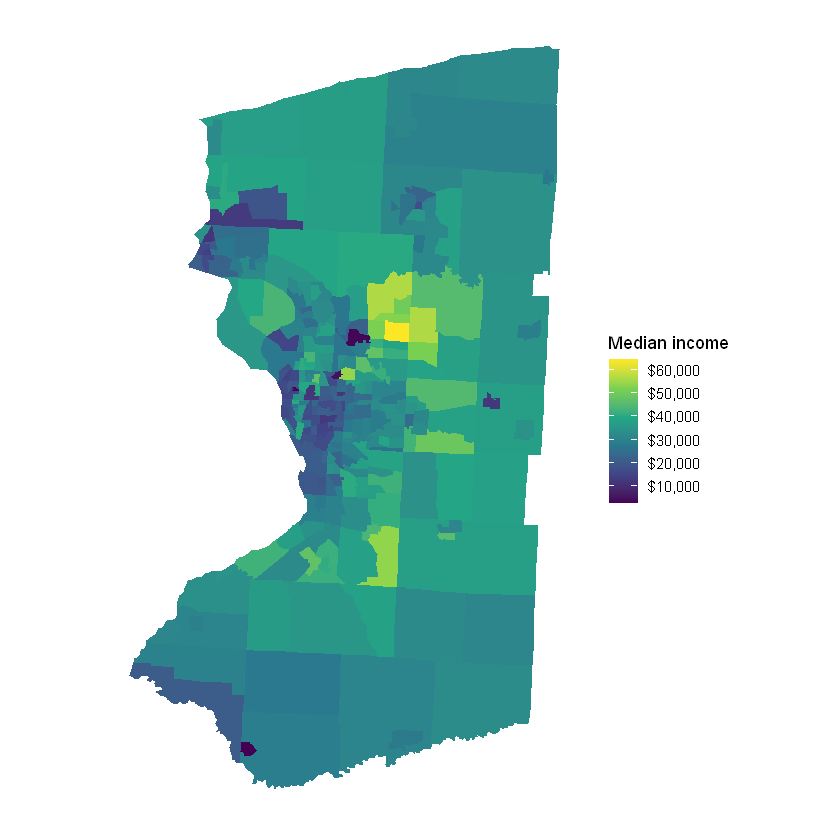

In [7]:
inc_breaks <- seq(0, 60000, by=10000)

ggplot(tracts, aes(fill = income_k*1000)) + 
  geom_sf(color = NA) + 
  scale_fill_viridis_c("Median income", 
                       breaks = inc_breaks,
                      labels = paste("$",prettyNum(inc_breaks, 
                                  big.mark = ",",scientific = FALSE),sep="")) + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank()) 

And residential density. To make the variation easier to see, I'm using a log scale.

Warning message:
"Transformation introduced infinite values in discrete y-axis"


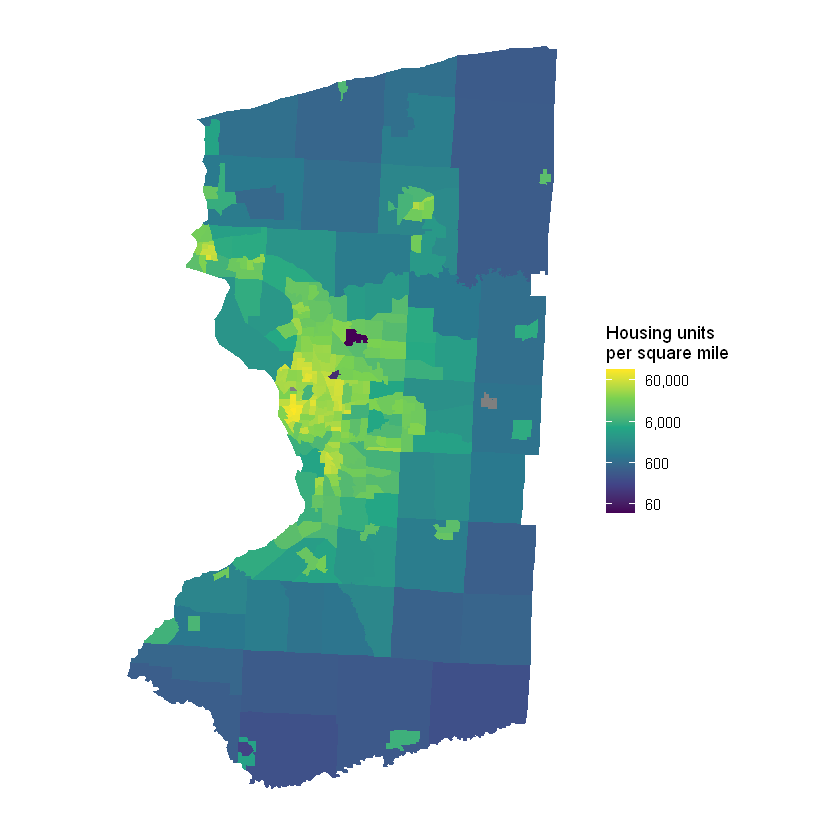

In [8]:
dens_breaks <- c(6, 60, 600, 6000, 60000)

ggplot(tracts, aes(fill = HBRESDN)) + 
  geom_sf(color = NA) + 
  scale_fill_viridis_c("Housing units\nper square mile", 
                       trans = "log",
                       breaks = dens_breaks,
                       labels = prettyNum(dens_breaks, big.mark = ",")) + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank()) 

And finally, lets look at race. One approach could be to create five different chloropleth maps, each showning the percentage of the population identifying in one of our race/ethnicity categories.

Another approach is to create a dot density map showing the spatial distribution of all five race/ethnicity categories on a single map.

We'll start by creating five set of points, one for each race/ethnicity category, where each point represents 100 households, and they are distributed randomly with their respective zones.

It takes a while to create all these points, so be patient (maybe go get a snack while you wait).

In [9]:
white_pts <- st_sample(tracts, size = ceiling(tracts$num_HH * tracts$pct_white / 100))
black_pts <- st_sample(tracts, size = ceiling(tracts$num_HH * tracts$pct_black / 100))
asian_pts <- st_sample(tracts, size = ceiling(tracts$num_HH * tracts$pct_asian / 100))
hisp_pts <- st_sample(tracts, size = ceiling(tracts$num_HH * tracts$pct_hisp / 100))
other_pts <- st_sample(tracts, size = ceiling(tracts$num_HH * tracts$pct_other / 100))

Then we'll put each of those five sets of points into its own dataframe with a column indicating the race/ethnicity category, and finally, we'll combine the five sets into a single dataframe.

In [11]:
white <- st_sf(data.frame(race_eth = rep("1.Non-Hispanic White", length(white_pts)), geom=white_pts))
black <- st_sf(data.frame(race_eth = rep("2.Non-Hispanic Black", length(black_pts)), geom=black_pts))
hisp <- st_sf(data.frame(race_eth = rep("3.Hispanic", length(hisp_pts)), geom=hisp_pts))
asian <- st_sf(data.frame(race_eth = rep("4.Asian", length(asian_pts)), geom=asian_pts))
other <- st_sf(data.frame(race_eth = rep("5.Other", length(other_pts)), geom=other_pts))

race_pts <- rbind(white, black, hisp, asian, other)

Now we can plot all these points on a map!

I'm making the dots transparent (alpha = 0.3) and tiny (size = 0.1) to avoid overplotting.

The guides() function at the end lets me adjust the dot sizes in the legend.

Keep in mind that a dot-density map like this can be a little deceptive by randomly (and somewhat evenly) distributing points within a zone, and that generally won't match the actual spatial distribuution of the population within zones.

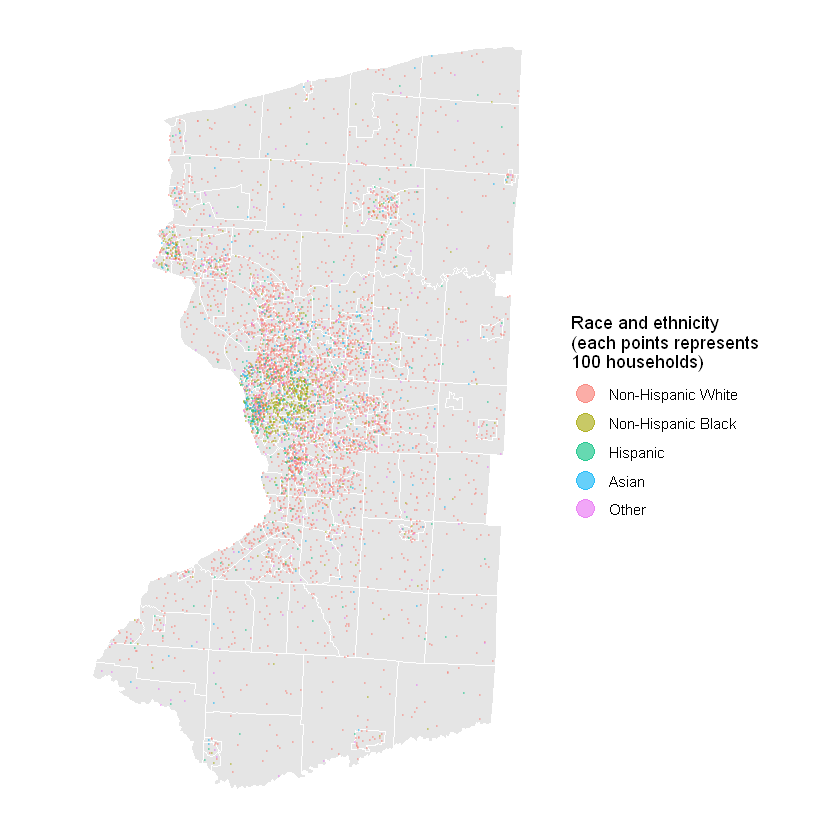

In [12]:
ggplot(tracts) + 
  geom_sf(color = "white") +
  geom_sf(data = race_pts, 
          aes(color = race_eth), 
          alpha = 0.3,
          size = 0.1) +
  scale_color_hue("Race and ethnicity\n(each points represents\n100 households)", 
                  labels = c("Non-Hispanic White",
                             "Non-Hispanic Black",
                             "Hispanic",
                             "Asian",
                             "Other")) + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank(),
       legend.key = element_blank())  +
  guides(color = guide_legend(override.aes = list(size=5, alpha = 0.6)))

#### Step 1.3 Load coefficient estimates from assignment 1.2.1

In [13]:
model_results <- read_csv("prod_model.csv")
model_results

Parsed with column specification:
cols(
  variable = col_character(),
  coefficient = col_double(),
  SE = col_double()
)



variable,coefficient,SE
<chr>,<dbl>,<dbl>
(Intercept),0.4603455224,5.964516e-01
HHSIZE,1.7243979206,2.426806e-01
HHVEHCNT,0.7998154336,3.492903e-01
income_k,0.0170357685,5.466478e-03
race_eth2.Non-Hispanic Black,0.9744132839,1.077636e+00
race_eth3.Asian,-2.1590017758,2.032990e+00
race_eth4.Hispanic,-1.2545194219,1.109555e+00
race_eth5.Other,0.9418612195,1.106677e+00
HBRESDN,0.0002523581,9.845979e-05


#### Step 1.4: Estimate zonal productions
If you multiply each model coefficient by the average value for each tract, you'll get an average number of trips per household. Multiplying this by the total number of households gives you the total number of trip productions in each tract.

In [16]:
tracts <- tracts %>%
  mutate(productions = num_HH*(model_results$coefficient[model_results$variable == "(Intercept)"] +
                               model_results$coefficient[model_results$variable == "HHSIZE"] * HHSIZE +
                               model_results$coefficient[model_results$variable == "HHVEHCNT"] * HHVEHCNT +
                               model_results$coefficient[model_results$variable == "income_k"] * income_k +
                               model_results$coefficient[model_results$variable == "race_eth2.Non-Hispanic Black"] * pct_black +
                               model_results$coefficient[model_results$variable == "race_eth3.Asian"] * pct_asian +
                               model_results$coefficient[model_results$variable == "race_eth4.Hispanic"] * pct_hisp +
                               model_results$coefficient[model_results$variable == "race_eth5.Other"] * pct_other +
                               model_results$coefficient[model_results$variable == "HBRESDN"] * HBRESDN))
head(tracts)

,GEOID,HHSIZE,HHVEHCNT,income_k,pct_white,pct_black,pct_hisp,pct_asian,pct_other,HBRESDN,num_HH,geometry,productions
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>,<dbl>
1,36029017300,2.37,1.7742156,42.048,0.9828964,0.003364643,0.005888126,0.00364503,0.004205804,8638.4119,2932,MULTIPOLYGON (((-197779.6 4...,25961.364
2,36029017400,3.13,1.1489971,19.423,0.4717327,0.257267109,0.136873426,0.01808194,0.116044862,5408.0001,1396,MULTIPOLYGON (((-207485.7 4...,12035.709
3,36029017501,2.09,1.3121212,28.829,0.8766737,0.003523608,0.021141649,0.01973221,0.078928823,3441.7670,660,MULTIPOLYGON (((-215285.5 4...,4278.201
4,36029017502,2.43,1.9789474,28.630,0.9750859,0.003865979,0.010309278,0.00000000,0.010738832,256.5629,950,MULTIPOLYGON (((-215157.7 4...,6447.511
5,36029000110,2.73,1.2553191,20.791,0.7019095,0.018741160,0.262376238,0.00000000,0.016973126,3770.6634,1034,MULTIPOLYGON (((-207344.1 4...,7427.031
6,36029005801,2.58,0.9292717,17.535,0.5062534,0.110386079,0.249320283,0.04323002,0.090810223,61713.5164,1428,MULTIPOLYGON (((-209712.6 4...,30433.742


### Step 2: Estimate trip attractions
We're not going to estimate our own trip attraction model like we did for the trip productions, since there just isn't a lot of good, publicly-available data that would allow us to do that. 

In 2012, TRB published a report called *Travel Demand Forecasting: Parameters and Techniques* (more commonly referenced by its number: NCHRP 716), which documents some common model parameters used in travel demand models in the United States. Table 4.4 of NCHRP 716 gives common coefficents for estimating trip attraction based on employment data, and we'll use those instead of estimating our own model.

To estimate trip attractions using the NCHRP 716 coefficients, we will:
1. Load zonal employment data
2. Visualize zonal employment data
3. Estimate zonal attractions

#### Step 2.1: Load zonal employment data
We need numbers in three categories: Basic, Retail, and Service. We can get these data from LEHD, using the lehdr package. 

For more information on LEHD variable names and file structures, refer to https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.4.pdf

In [17]:
employment <- grab_lodes(state = "ny", 
                     year = 2017, 
                     lodes_type = "wac", 
                     job_type = "JT00", 
                     segment = "S000",
                     agg_geo = "tract") %>%
  mutate(county = substr(w_tract,1,5)) %>%
  filter(county == "36029" |
        county == "36063") %>%
  rename(total_emp = C000) %>%
  mutate(basic_emp = CNS01+CNS02+CNS03+CNS04+CNS05+CNS06+CNS08+CNS09) %>%
  mutate(retail_emp = CNS07) %>%
  mutate(service_emp = total_emp - basic_emp - retail_emp) %>%
  rename(GEOID = w_tract) %>%
  select(GEOID, total_emp, basic_emp, retail_emp, service_emp)

tracts <- inner_join(tracts, employment) 

Cached version of file found in C:/Users/cav223/Documents/GitHub/assignment-2-2/lodes_raw/ny_wac_S000_JT00_2017.csv.gz
Reading now...

Joining, by = "GEOID"



#### Step 2.2: Visualize zonal employment data
Again, this step is basically optional - you can move on to estimating attractions without visualizing your input first, but the visualization step can be informative.

I'm just going to map the variation in total employment using a chloropleth map, although you could certainly map each of the different employment types (perhaps with another dot density map!).

I'm using a log scale here to make it easier to see the variation

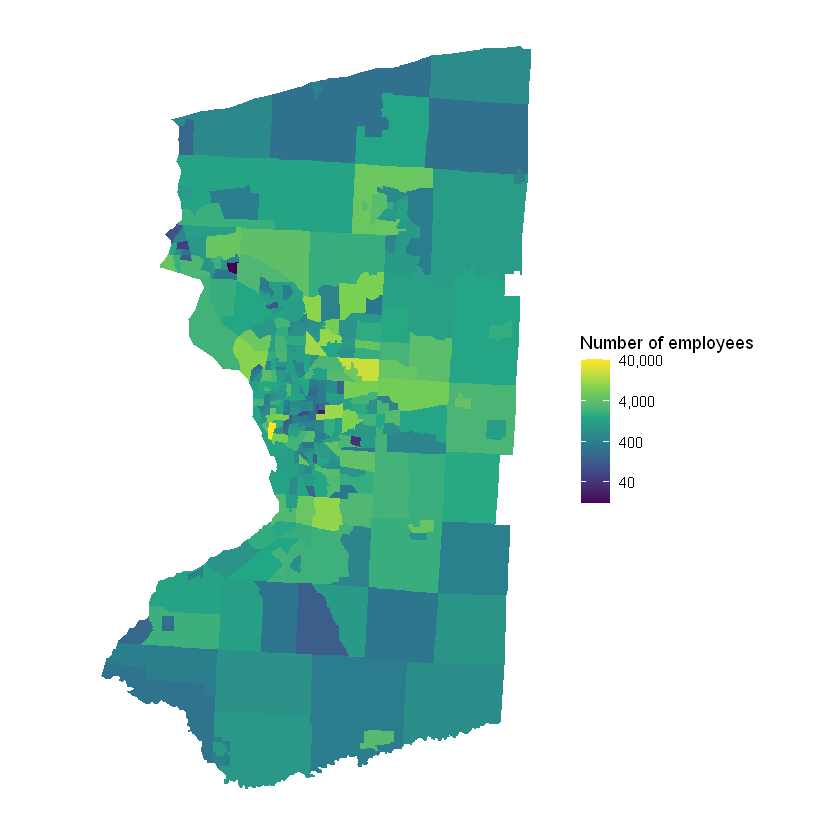

In [18]:
emp_breaks <- c(4, 40, 400, 4000, 40000)

ggplot(tracts, aes(fill = total_emp)) + 
  geom_sf(color = NA) + 
  scale_fill_viridis_c("Number of employees",
                       trans = "log",
                       breaks = emp_breaks,
                       labels = prettyNum(emp_breaks, big.mark = ",")) + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank()) 

#### Step 2.3: Estimate zonal attractions
If you refer to Table 4.4 of NCHRP 716 and add together:
* Model 1 for Home-based work person trips
* Model 3 for Home-Based Nonwork person trips
* Model 1 for Nonhome Based person trips

You'll get:

Total person trips = 1.3(Households) + 2.4(Basic employment) + 14.3(Retail employment) + 6.1(Service employment)

In [20]:
tracts <- tracts %>%
  mutate(attractions = (1.3*num_HH) +
                       (2.4*basic_emp) +
                      (14.3*retail_emp) +
                       (6.1*service_emp)) 
head(tracts)

paste("The study area has ", prettyNum(sum(tracts$productions, na.rm = TRUE), 
                                       big.mark = ",", scientific = FALSE),
      " productions and ",
     prettyNum(sum(tracts$attractions, na.rm = TRUE), 
                                       big.mark = ",", scientific = FALSE),
      " attractions.")

,GEOID,HHSIZE,HHVEHCNT,income_k,pct_white,pct_black,pct_hisp,pct_asian,pct_other,HBRESDN,num_HH,productions,total_emp,basic_emp,retail_emp,service_emp,geometry,attractions
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [m]>,<dbl>
1,36029017300,2.37,1.7742156,42.048,0.9828964,0.003364643,0.005888126,0.00364503,0.004205804,8638.4119,2932,25961.364,1912,165,86,1661,MULTIPOLYGON (((-197779.6 4...,15569.5
2,36029017400,3.13,1.1489971,19.423,0.4717327,0.257267109,0.136873426,0.01808194,0.116044862,5408.0001,1396,12035.709,1290,979,34,277,MULTIPOLYGON (((-207485.7 4...,6340.3
3,36029017501,2.09,1.3121212,28.829,0.8766737,0.003523608,0.021141649,0.01973221,0.078928823,3441.7670,660,4278.201,413,20,109,284,MULTIPOLYGON (((-215285.5 4...,4197.1
4,36029017502,2.43,1.9789474,28.630,0.9750859,0.003865979,0.010309278,0.00000000,0.010738832,256.5629,950,6447.511,903,159,47,697,MULTIPOLYGON (((-215157.7 4...,6540.4
5,36029000110,2.73,1.2553191,20.791,0.7019095,0.018741160,0.262376238,0.00000000,0.016973126,3770.6634,1034,7427.031,1179,751,60,368,MULTIPOLYGON (((-207344.1 4...,6249.4
6,36029005801,2.58,0.9292717,17.535,0.5062534,0.110386079,0.249320283,0.04323002,0.090810223,61713.5164,1428,30433.742,148,65,0,83,MULTIPOLYGON (((-209712.6 4...,2518.7


[1] "The study area has  5,611,293  productions and  3,982,718  attractions."

### Step 3: Balance productions and attractions
Each trip in the model has a production and an attraction, so these two numbers should be the same. But since we estimated them with two completely different models, they won't match unless our models are perfect (which would be bad news since it would probably imply that we're living in a simulated reality, and a simple one at that). 

Trip production models are usually based on better data than trip attraction models, so we'll assume that the total number of trips actually matches the total number of trip productions, and we'll adjust the trip attractions proportionately so that the total is equal to the total number of productions.

In [21]:
tracts <- tracts %>%
  mutate(bal_attr = (attractions/sum(attractions, na.rm = TRUE)*
                     sum(productions, na.rm = TRUE)))

paste("The study area has ", prettyNum(sum(tracts$productions, na.rm = TRUE), 
                                       big.mark = ",", digits = 2),
      " productions and ",
     prettyNum(sum(tracts$bal_attr, na.rm = TRUE), 
                                       big.mark = ",", digits = 2),
      " attractions (balanced).")

[1] "The study area has  5,611,293  productions and  5,611,293  attractions (balanced)."

In [22]:
trip_gen <- tracts %>%
  select(GEOID, productions, bal_attr) %>%
  rename(attractions = bal_attr) %>%
  mutate(productions = replace_na(productions, 0)) %>%
  mutate(attractions = replace_na(attractions, 0))

head(trip_gen)

,GEOID,productions,attractions,geometry
,<chr>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
1,36029017300,25961.364,21936.029,MULTIPOLYGON (((-197779.6 4...
2,36029017400,12035.709,8932.914,MULTIPOLYGON (((-207485.7 4...
3,36029017501,4278.201,5913.337,MULTIPOLYGON (((-215285.5 4...
4,36029017502,6447.511,9214.837,MULTIPOLYGON (((-215157.7 4...
5,36029000110,7427.031,8804.844,MULTIPOLYGON (((-207344.1 4...
6,36029005801,30433.742,3548.622,MULTIPOLYGON (((-209712.6 4...


### Step 4: Visualize final result
It would be nice to have a map that shows where there are a lot of prodcutions and where there are a lot of attractions. This is another good application of a dot density map.

We'll start by creating two set of points, one for productions and one for attractions, where each point represents 10,000 trip ends, and they are distributed randomly with their respective zones.

Then we'll put each of those two sets of points into its own dataframe with a column indicating whether the point is a production or an attraction, and finally, we'll combine the two sets into a single dataframe. 

Again, it takes a while to create all these points, so be patient.

In [23]:
prod_pts <- st_sample(trip_gen, size = ceiling(trip_gen$productions / 10000))
attr_pts <- st_sample(trip_gen, size = ceiling(trip_gen$attractions / 10000))

prods <- st_sf(data.frame(P_or_A=rep("Production", length(prod_pts)), geom=prod_pts))
attrs <- st_sf(data.frame(P_or_A=rep("Attraction", length(attr_pts)), geom=attr_pts))

trip_gen_pts <- rbind(prods, attrs)

Now plot all those points on a map! To avoid overplotting, I'm making the points pretty small (size = 0.5) and pretty transparent (alpha = 0.3).

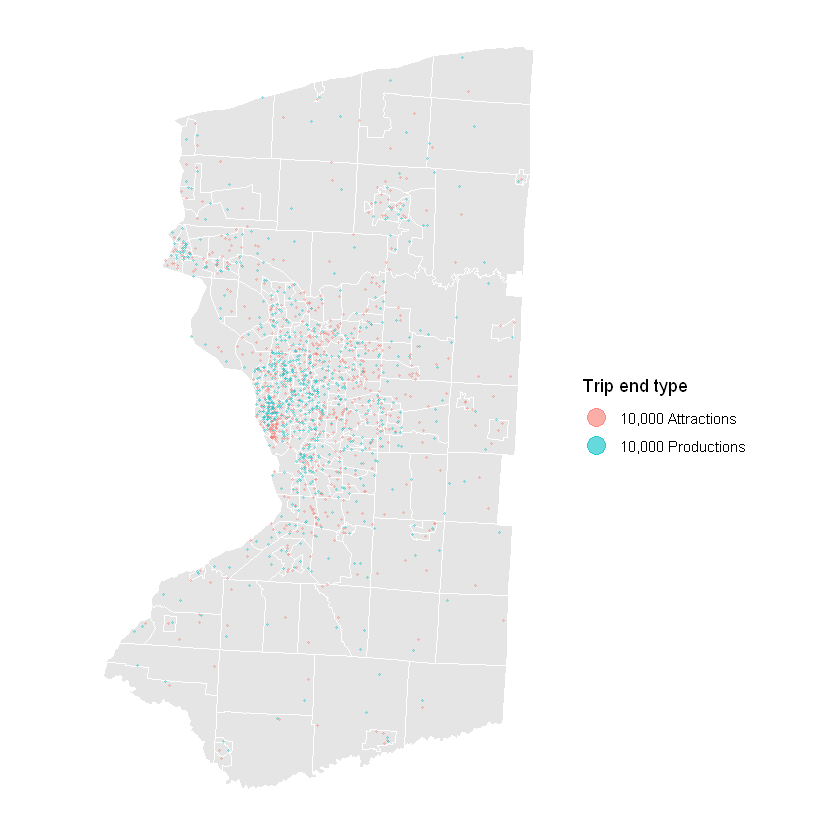

In [24]:
ggplot(trip_gen) + 
  geom_sf(color = "white") +
  geom_sf(data = trip_gen_pts, 
          aes(color = P_or_A), 
          alpha = 0.3,
          size = 0.5) +
  scale_color_hue("Trip end type", labels = c("10,000 Attractions","10,000 Productions")) + 
  theme(axis.text=element_blank(),
        axis.ticks=element_blank(),
        panel.background = element_blank(),
       legend.key = element_blank())  +
  guides(color = guide_legend(override.aes = list(size=5, alpha = 0.6)))